In [2]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
plt.ioff()
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
import os
from tqdm import tqdm
from scipy.spatial import distance
from scipy.cluster import hierarchy

import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

f = all_data['e'][2]

data = np.load("../cnmf_f01555.npz")
cnmf = data['cnmf'].astype(np.float32)
raw = data['raw'].astype(np.float32)
del data
# cnmf_t = T.from_numpy(raw).cuda()
neurons = T.from_numpy(cnmf).cuda()
neurons_norm = (neurons - neurons.mean(0))/(neurons.std(0)+1e-8)
neurons = neurons_norm

def corrcoef(x):
    # calculate covariance matrix of rows
    mean_x = torch.mean(x, 1, keepdim=True)
    xm = x.sub(mean_x.expand_as(x))
    c = xm.mm(xm.t())
    c = c / (x.size(1) - 1)

    # normalize covariance matrix
    d = torch.diag(c)
    stddev = torch.pow(d, 0.5)
    c = c.div(stddev.expand_as(c)+1e-8)
    c = c.div(stddev.expand_as(c).t()+1e-8)

    # clamp between -1 and 1
    # probably not necessary but numpy does it
    c = torch.clamp(c, -1.0, 1.0)

    return c

neuron_corr = corrcoef(neurons)

neuron_linkage = hierarchy.linkage(
    distance.pdist(neuron_corr), method='ward')

neuron_linkage_clusters = hierarchy.fcluster(neuron_linkage,4,criterion='maxclust')
# includes all neurons, even those without cluster
cluster_by_neuron = np.zeros(neurons.shape[0]+1)
for i,v in enumerate(neuron_linkage_clusters):
    cluster_by_neuron[i] = v
cluster_by_neuron = cluster_by_neuron[:-1]

# nclust = int(cluster_by_neuron.max())
# plt.subplots(nclust,1, figsize=[10,5*nclust])
# for clust in range(1,nclust+1):
#     #Select rois in raphe in this slices, and get their coordinates.
#     poly_coords = df[(cluster_by_neuron==clust) & (df.z==z)].poly
#     poly_coords = [np.round(poly[~np.isnan(poly).any(axis=1)])[:,(1,0)].astype(int) for poly in poly_coords]
#     plt.subplot(nclust,1,clust)
#     #Overlay the ROIs on the background image and display:
#     img = vizutil.overlay_coords(back_img, poly_coords, [0,0,1], alpha=.5)
#     plt.imshow(img,interpolation='nearest')
#     plt.title("Cluster {}".format(clust))

dtype = np.float32
# x_fish = F.normalize(neurons,0)
x_fish = neurons
time_fish = T.from_numpy(f.frame_st.mean(1).astype(dtype)).cuda()
if dtype==np.float16:
    u_fish = T.cuda.HalfTensor(time_fish.shape).zero_()
    p_fish = T.cuda.HalfTensor(time_fish.shape).zero_()
else:
    u_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
    p_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
u_fish[numpy.searchsorted(f.frame_et[:,-1], f.shock_st,side="left")] = 1

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
class FishSeqData(Dataset):    
    def __init__(self, u, p, x,n_future_steps=1):
        self.x = nn.Parameter(x,requires_grad=False)
        self.p = nn.Parameter(p,requires_grad=False)
        self.u = nn.Parameter(u,requires_grad=False)
        self.nfeatures = x.shape[1]
        self.n_future_steps = n_future_steps
        
    def __len__(self):
        return len(self.x)-self.n_future_steps

    def __getitem__(self, idx):
        indices = slice(idx,idx+self.n_future_steps)
        x_true_indices = slice(idx+1,idx+self.n_future_steps+1)
        return (self.u[indices], self.p[indices],
                self.x[indices], self.x[x_true_indices])
    
# def train(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6),
#           lambdaC=(1e-5, 1e-5), lambdaD=(1e-5, 1e-5), lr=0.1, verbose=True):
def train(model,data,nepochs=10, lambda1=1e-5,
      lambda2=1e-5, lr=0.1, verbose=True, optimizer=None):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    if verbose:
        A_loss = F.mse_loss(model.A.data,A_true)
        print("A_loss: {}".format(A_loss))
    cum_mse_loss = 0
    with T.no_grad():
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            cum_mse_loss += F.mse_loss(X_pred.float(),X_true.float())
        nfeatures = X_true.shape[2]
        print("mse_loss: {:3E}".format(cum_mse_loss/nfeatures))
        if optimizer==None:
            # optimizer = T.optim.SGD(model.parameters(),lr=lr)
            optimizer = T.optim.Adam(model.parameters(),lr=lr,amsgrad=True)
    
    for e in range(nepochs):
        if verbose:
            print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_mse_loss = 0
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            reg = 0
            for param in model.parameters():
                reg += lambda1 * param.norm(1) + lambda2 * param.norm(2)
#             l_A = lambdaA[0] * model.A.norm(1) + lambdaA[1] * model.A.norm(2)
#             l_B = lambdaB[0] * model.B.norm(1) + lambdaB[1] * model.B.norm(2)
#             l_C = lambdaC[0] * model.C.norm(1) + lambdaC[1] * model.C.norm(2)
#             l_D1 = lambdaD[0] * model.Dense1.norm(1) + lambdaD[1] * model.Dense1.norm(2)
#             l_D2 = lambdaD[0] * model.Dense2.norm(1) + lambdaD[1] * model.Dense2.norm(2)
            mse_loss = F.mse_loss(X_pred,X_true)
#             loss = mse_loss + l_A + l_B + l_C + l_D1 #+ l_D2
            loss = mse_loss + reg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_mse_loss += float(mse_loss)
#             del X_pred, U,P,X, X_true, mse_loss, l_A, l_B, loss
#             gc.collect()
#             torch.cuda.empty_cache()

        if verbose:
            A_loss = F.mse_loss(model.A.data,A_true)
            B_loss = F.mse_loss(model.B.data,B_true)
            C_loss = F.mse_loss(model.C.data,C_true)
            print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))
        print("cum_loss: {:3E}, mse_loss: {:3E}".format(cum_loss,cum_mse_loss/nfeatures))
    
    if verbose:
        print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))

In [39]:
class Shock(nn.Module):
    def __init__(self, nfeatures, n_future_steps,dtype=T.float32, scale=1,std=0.1):
        super(Shock, self).__init__()
        if dtype==T.float32:
            tensor = T.cuda.FloatTensor
        elif dtype==T.float16:
            tensor = T.cuda.HalfTensor
                
        self.C = nn.Parameter(tensor(nfeatures).normal_(std),requires_grad=True)
        self.n_future_steps = n_future_steps
        self.tensor = tensor
        self.scale = scale
        self.dtype = dtype

    def forward(self, u, p, x_true, n_future_steps=None):
        if n_future_steps==None:
            n_future_steps = self.n_future_steps
        x = self.tensor(x_true.shape[0], 1+x_true.shape[1], *x_true.shape[2:]).zero_()
        x[:,0] = x_true[:,0]
        for t in range(n_future_steps):
            dxdt = u[ :,t,None]*self.C
            x[:,t+1] = dxdt + x[:,t]
        return x[:,1:]

    def predict(self, u, p, x_init,x_true=None):
        # if given x_true, use ground truth for each timestep
        with T.no_grad():
            x = T.cuda.FloatTensor(1+u.shape[0], x_init.shape[0]).zero_()
            x[0] = x_init
            n_future_steps = u.shape[0]
            for t in range(n_future_steps):
                if type(x_true)!=type(None):
                    X = x_true
                else:
                    X = x
                x[t+1] = self(u[None,[t]], p[None,[t]], X[None,[t]],1)
        return x[1:]

    
ntrain = int(np.floor(len(x_fish)*0.8))

train_data = (u_fish[:ntrain],p_fish[:ntrain],x_fish[:ntrain])
test_data = (u_fish[ntrain:],p_fish[ntrain:],x_fish[ntrain:])


    
n_future_steps = 1
batch_size = 8

data = FishSeqData(u_fish[:ntrain],p_fish[:ntrain],x_fish[:ntrain],n_future_steps)
model = Shock(data.nfeatures,n_future_steps, std=0.01)

In [40]:
zeroModel = Shock(data.nfeatures,n_future_steps)
zeroModel.C.data.zero_()
train(zeroModel,data,0,0,0, lr=1e-3,verbose=False)

100%|██████████| 283/283 [00:00<00:00, 1742.87it/s]

mse_loss: 3.324672E-03


In [43]:
train(model,data,7,0,0, lr=1e-2,verbose=False)
print("Total C weight:", model.C.sum())

 29%|██▉       | 82/283 [00:00<00:00, 811.36it/s]

mse_loss: 3.279236E-03


 29%|██▉       | 82/283 [00:00<00:00, 817.76it/s]

cum_loss: 1.925473E+01, mse_loss: 3.288595E-03


 30%|███       | 86/283 [00:00<00:00, 857.43it/s]

cum_loss: 1.938758E+01, mse_loss: 3.311286E-03


 29%|██▉       | 82/283 [00:00<00:00, 813.93it/s]

cum_loss: 1.921223E+01, mse_loss: 3.281337E-03


 29%|██▉       | 82/283 [00:00<00:00, 815.39it/s]

cum_loss: 1.921283E+01, mse_loss: 3.281439E-03


 29%|██▉       | 82/283 [00:00<00:00, 817.16it/s]

cum_loss: 1.927600E+01, mse_loss: 3.292229E-03


 30%|███       | 86/283 [00:00<00:00, 857.38it/s]

cum_loss: 1.922623E+01, mse_loss: 3.283728E-03


100%|██████████| 283/283 [00:00<00:00, 778.51it/s]

cum_loss: 1.921875E+01, mse_loss: 3.282451E-03
Total C weight: tensor(536.7377, device='cuda:0')


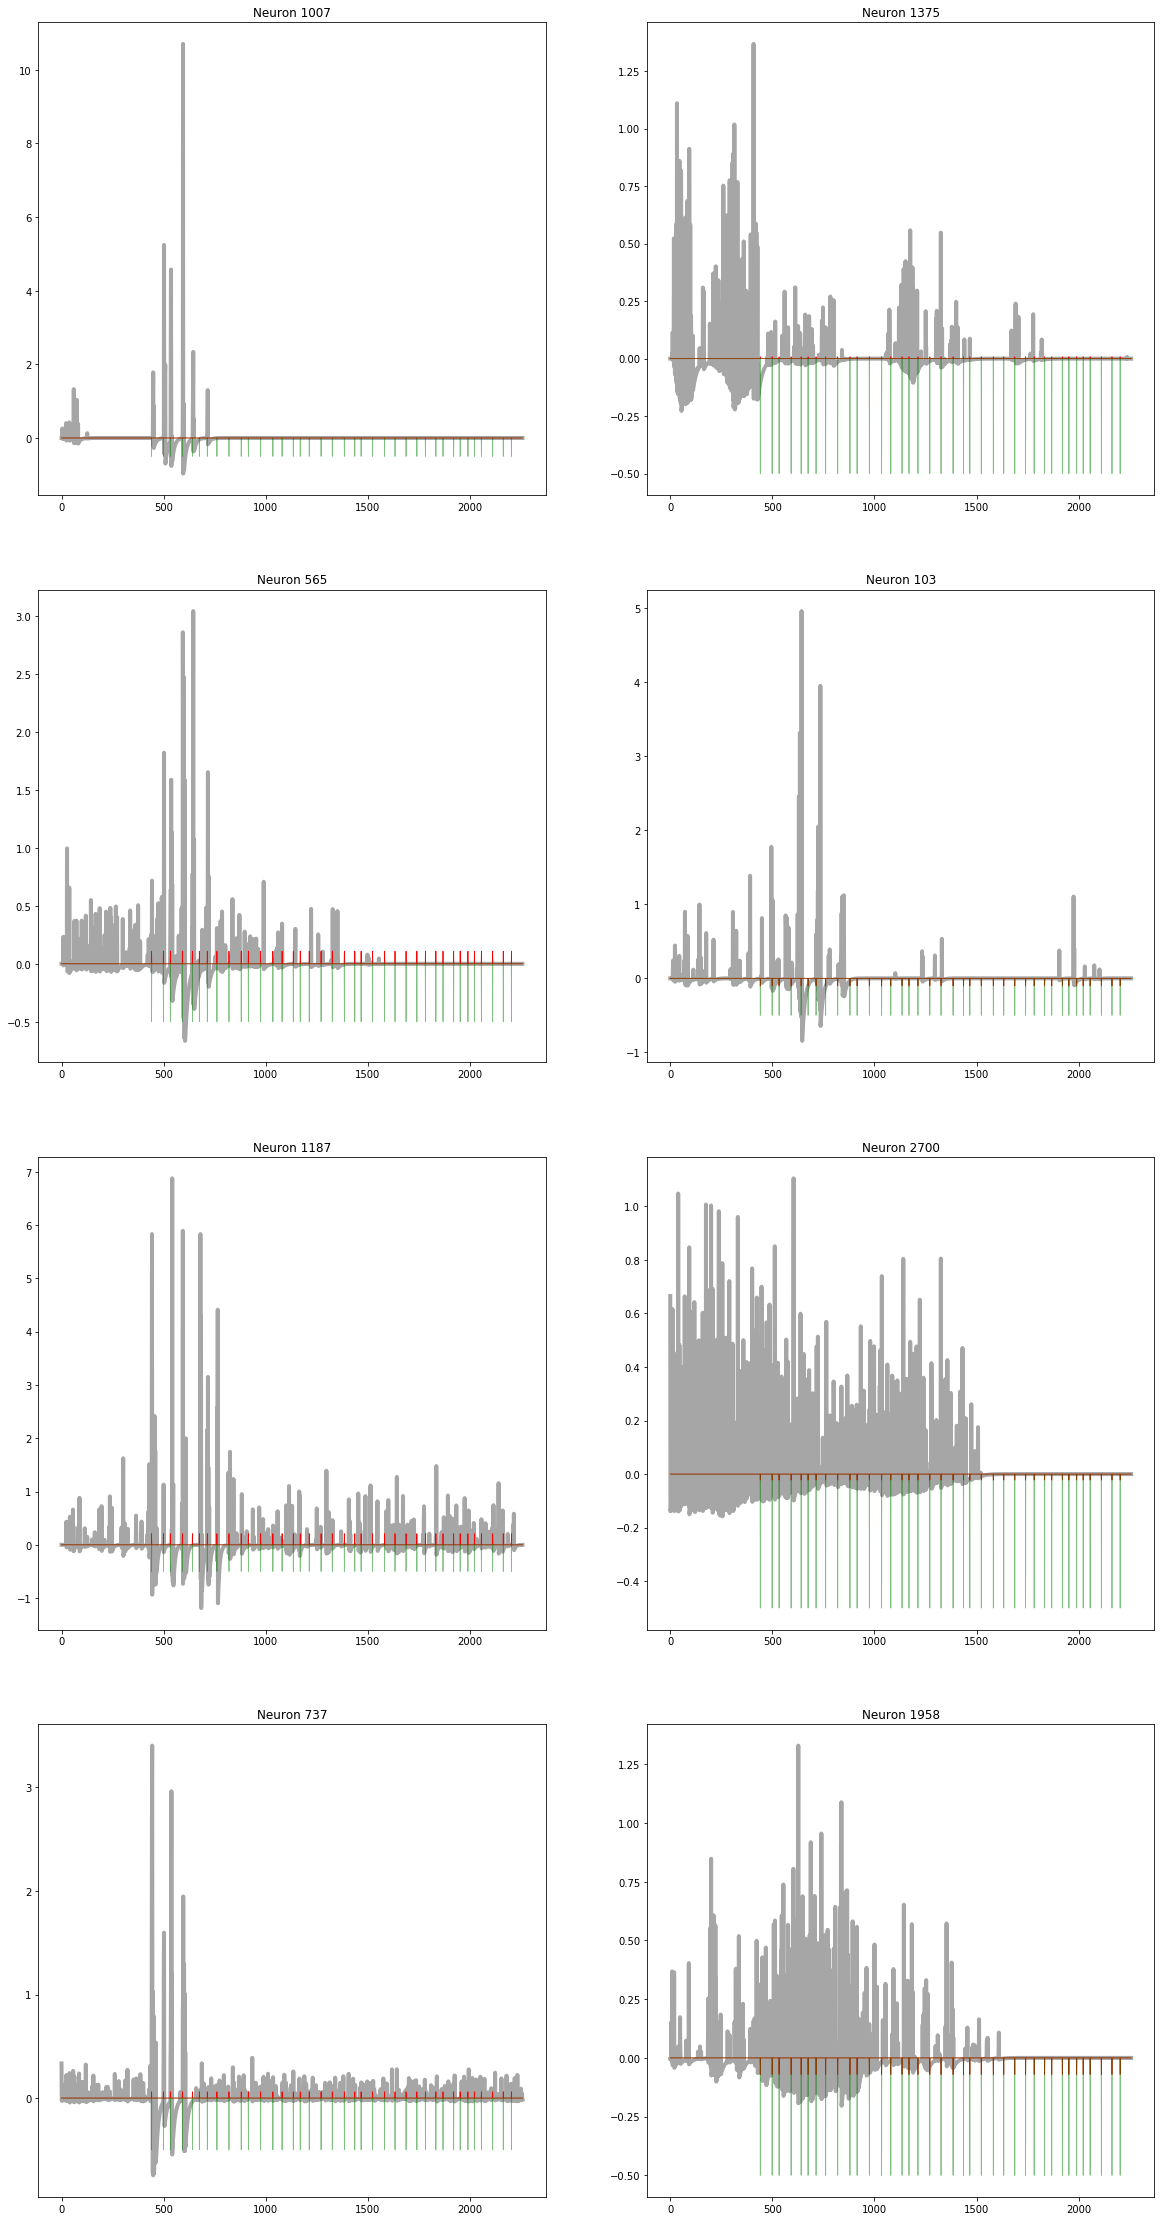

In [44]:
# U,P,X = test_data
U,P,X = train_data
X_pred = model.predict(U,P,X[0],X)
dx_true = X[1:] - X[:-1]
dx_pred = X_pred[:-1] - X[:-1]

ncol, nrow = (2,4)
plt.close('all')
fig, ax = plt.subplots(nrow, ncol, figsize=(20,40))

# ax.set_ylabel("dx/dt")
# ax.set_xlabel("Time")
# ax.set_title("Training data")

for i in range(nrow):
    for j in range(ncol):
        n = np.random.randint(0,len(x_fish))
#         ax[i,j].plot(dx_pred[:,n].cpu().numpy(),color='red', alpha=0.6,linewidth=1, label="Model")
#         ax[i,j].plot(dx_true[:,n].cpu().numpy(),color="gray", linewidth=1, alpha=0.6,label="Truth")
        ax[i,j].plot(dx_true[:,n].cpu().numpy(),color="gray", linewidth=4, alpha=0.7,label="Truth")
        ax[i,j].plot(dx_pred[:,n].cpu().numpy(),color='red', alpha=1,linewidth=0.8, label="Model")
        ax[i,j].plot((-0.5*U).cpu().numpy(),color='green', alpha=0.5,linewidth=0.8, label="Model")
        ax[i,j].set_title("Neuron {}".format(n))
fig

In [45]:
# shock predict same time

ntrain = int(np.floor(len(x_fish)*0.8))-1
train_data = (u_fish[1:ntrain+1],p_fish[:ntrain],x_fish[:ntrain])
test_data = (u_fish[ntrain+1:],p_fish[ntrain:-1],x_fish[ntrain:-1])


    
n_future_steps = 1
batch_size = 8

data = FishSeqData(u_fish[:ntrain],p_fish[:ntrain],x_fish[:ntrain],n_future_steps)
model = Shock(data.nfeatures,n_future_steps, std=0.01)

train(model,data,7,0,0, lr=1e-2,verbose=False)
print("Total C weight:", model.C.sum())

 29%|██▊       | 81/283 [00:00<00:00, 805.70it/s]

mse_loss: 4.144578E-03


 29%|██▊       | 81/283 [00:00<00:00, 806.36it/s]

cum_loss: 2.201209E+01, mse_loss: 3.759537E-03


 30%|███       | 85/283 [00:00<00:00, 849.08it/s]

cum_loss: 1.996897E+01, mse_loss: 3.410583E-03


 29%|██▉       | 83/283 [00:00<00:00, 824.03it/s]

cum_loss: 1.944389E+01, mse_loss: 3.320903E-03


 29%|██▊       | 81/283 [00:00<00:00, 809.39it/s]

cum_loss: 1.929456E+01, mse_loss: 3.295400E-03


 29%|██▊       | 81/283 [00:00<00:00, 808.59it/s]

cum_loss: 1.923552E+01, mse_loss: 3.285315E-03


 30%|███       | 85/283 [00:00<00:00, 849.34it/s]

cum_loss: 1.922871E+01, mse_loss: 3.284152E-03


100%|██████████| 283/283 [00:00<00:00, 777.71it/s]

cum_loss: 1.921227E+01, mse_loss: 3.281344E-03
Total C weight: tensor(528.9603, device='cuda:0')


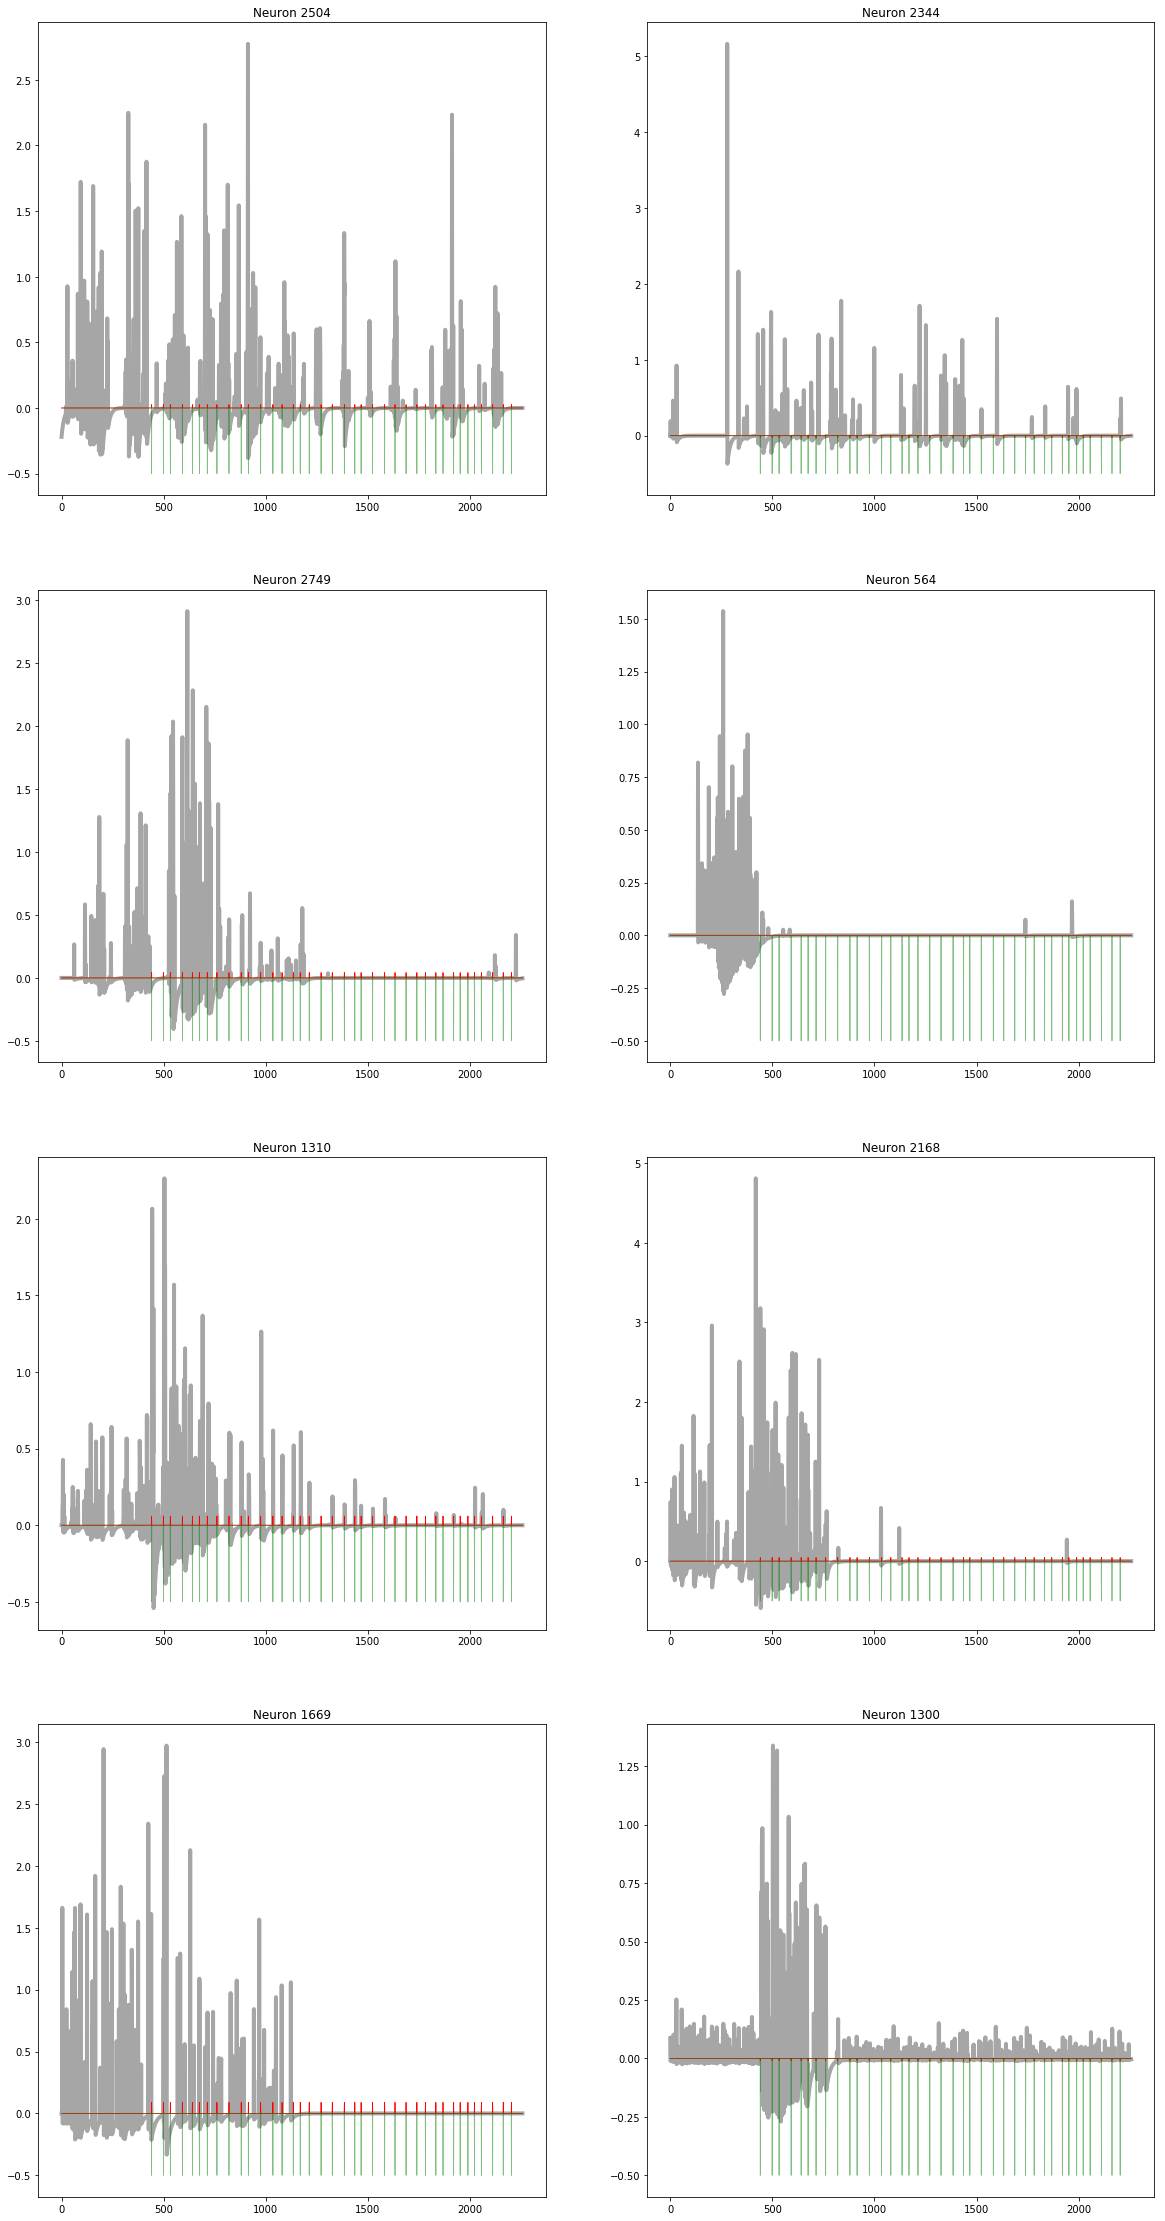

In [46]:
# U,P,X = test_data
U,P,X = train_data
X_pred = model.predict(U,P,X[0],X)
dx_true = X[1:] - X[:-1]
dx_pred = X_pred[:-1] - X[:-1]

ncol, nrow = (2,4)
plt.close('all')
fig, ax = plt.subplots(nrow, ncol, figsize=(20,40))

# ax.set_ylabel("dx/dt")
# ax.set_xlabel("Time")
# ax.set_title("Training data")

for i in range(nrow):
    for j in range(ncol):
        n = np.random.randint(0,len(x_fish))
#         ax[i,j].plot(dx_pred[:,n].cpu().numpy(),color='red', alpha=0.6,linewidth=1, label="Model")
#         ax[i,j].plot(dx_true[:,n].cpu().numpy(),color="gray", linewidth=1, alpha=0.6,label="Truth")
        ax[i,j].plot(dx_true[:,n].cpu().numpy(),color="gray", linewidth=4, alpha=0.7,label="Truth")
        ax[i,j].plot(dx_pred[:,n].cpu().numpy(),color='red', alpha=1,linewidth=0.8, label="Model")
        ax[i,j].plot((-0.5*U).cpu().numpy(),color='green', alpha=0.5,linewidth=0.8, label="Model")
        ax[i,j].set_title("Neuron {}".format(n))
fig